<a href="https://colab.research.google.com/github/fangyi99/rl_cartpole/blob/main/whales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SC3000 Assignment 1 - Balancing a Pole on a Cart

Done By: Looi Fang Yi (U2323220A)

## Introduction

The Cartpole environment is a classic control problem in reinforcement learning (RL) where an agent must balance a pole on a moving cart. The goal is to apply forces to the cart to prevent the pole from falling over, maintaining balance for as long as possible.

## Solutions

3 model-free reinforcement learning algorithms were covered in lectures:
1. Monte Carlo - relies on sampling by averaging returns from complete episodes
2. Q-learning - uses bootstraping to update value estimates incrementally
3. Deep Q-learning - extends Q-learning with function approximation using neural networks

In this project, I aim to explore 2 different reinforcement learning strategies - Q-learning & Monte Carlo - to analyse their effectiveness in solving the Cartpole problem.

To assess their performance, I will compare these 2 agents against a random policy agent as a baseline. The evaluation will focus on their average cumulative reward over 100 episodes. Since the Cartpole environment is considered solved when an agent consistently achives an average reward of at least 195, this threshold will be used as a measure of success.

## Installing Dependencies

In [ ]:
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install --upgrade setuptools > /dev/null 2>&1
!pip install gymnasium[box2d] moviepy pyvirtualdisplay > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1

## Import Dependencies

In [ ]:
import gymnasium as gym
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import defaultdict
import time

import glob
import io
import base64
from IPython.display import HTML, display
from gymnasium.wrappers import RecordVideo

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
from collections import deque

## Set up Environment

In [ ]:
env = gym.make("CartPole-v1")

## Training Parameters

In [ ]:
alpha = 0.1 # step size
gamma = 0.99 # discount rate
epsilon = 1 # probability of choosing exploration over best estimated action
train_episodes = 1000
test_episodes = 100
steps = 200 # total number of simulation steps
state_space = 4 # no. of dimensions in the state
action_space = 2 # no. of distinct actions agent can take

# neural network variables
h_size = 64 # hidden layer size for neural network
lr = 0.001

#state discretization variables
upper_bounds = env.observation_space.high
lower_bounds = env.observation_space.low
cart_velocity_min = -3
cart_velocity_max = 3
pole_angle_velocity_min = -10
pole_angle_velocity_max = 10
lower_bounds[1] = cart_velocity_min
upper_bounds[1] = cart_velocity_max
lower_bounds[3] = pole_angle_velocity_min
upper_bounds[3] = pole_angle_velocity_max

bins_position = 40
bins_velocity = 40
bins_angle = 40
bins_angle_velocity = 40

bins = [bins_position, bins_velocity, bins_angle, bins_angle_velocity]

## Helper Functions

This function will be used to plot the cumulative reward of each agent for every round.

In [ ]:
def plot_graph(rewards, title="Agent Performance"):
    plt.plot(rewards)
    plt.title(title)
    plt.xlabel('Episodes')
    plt.ylabel('Cumulative reward')
    plt.show()

This function will be used to render one episode played by a developed RL agent.

In [ ]:
def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    display(HTML(f'''
            <video alt="test" autoplay loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{encoded.decode('ascii')}" type="video/mp4" />
            </video>
        '''))
  else:
    print("Could not find video")

## Random Policy Agent

An example of a naive agent which randomly chooses an action regardless of the observation.

In [ ]:
class random_policy_agent:
    def __init__(self, env):
        self.env = env
        self.action_space = env.action_space.n

    def select_action(self, observation):
        return self.env.action_space.sample()

    def evaluate_agent(self, episodes):
        rewards_per_episode = []

        for episode in range(episodes):
            observation = self.env.reset()[0]  # reset environment at the start of each episode
            done = False
            episode_rewards = 0

            while not done:
                action = self.select_action(observation) # choose action
                next_observation, reward, done, _, _ = self.env.step(action) # step in the environment
                episode_rewards += reward # store reward for current step
                observation = next_observation # move to next state

            rewards_per_episode.append(episode_rewards) # store cumulative reward for current episode

        return rewards_per_episode

We call each round of the pole-balancing game an "episode". At the start of each episode, the environment is reset, which chooses a random initial state. The observation space is given below. The array defines the min and max values of the 4 observed values, corresponding to cart position, velocity, pole angle and angular velocity.

In [ ]:
# initialise agent
rand_agent_0 = random_policy_agent(env)

# get random initial state
observation, info = env.reset()
print("Observation:", observation)

Observation: [-0.03324017  0.03146158  0.00786168  0.02058568]


For the CartPole environment, there are two possible actions: 0 for pushing to the left and 1 for pushing to the right.
In this case, the action taken by the random policy agent is randomised.

In [ ]:
# get chosen action
action = rand_agent_0.select_action(observation)
print("Chosen action:", action)

Chosen action: 0


The agent plays the game over 100 episodes and the cumulative reward for each round is recorded and plotted in the graph below.

Evaluation result
Average cumulative reward: 23.07
Is my agent good enough? False


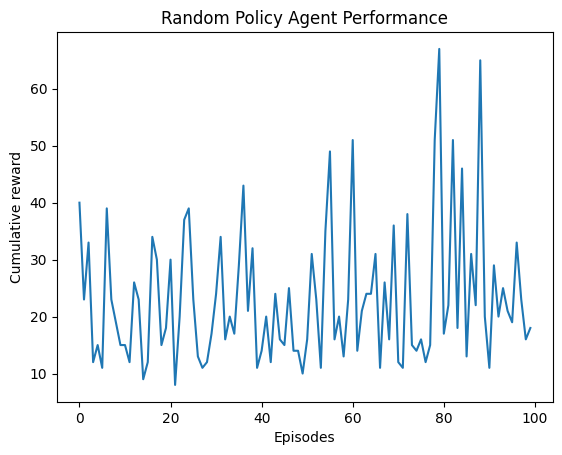

In [ ]:
rand_agent = random_policy_agent(env)
rand_rewards = rand_agent.evaluate_agent(test_episodes)

# results
print("Evaluation result")
print("Average cumulative reward:", np.mean(rand_rewards))
print("Is my agent good enough?", np.mean(rand_rewards) > 195)
plot_graph(rand_rewards, title="Random Policy Agent Performance")

Clearly, the naive strategy performs poorly by surviving for only a limited number of time steps per episode, as indicated by the average cumulative reward of 23.07. The random selection of actions without any learning mechanism leads to suboptimal performance.

## RL Algorithms

### Basic Concepts

**Value-Based vs Policy-Based**

In value-based approaches, the agent learns a value function that estimates the expected future reward for each state-action pair. The agent uses these values to select the best possible action at each state.

In policy-based approaches, the agent directly learns a policy, which is a mapping from states to actions. The goal is to improve the policy over time by exploring and evaluating actions based on the rewards it receives from interacting with the environment.

**On-Policy vs Off-Policy**

In on-policy approaches, the agent learns the value of the policy it is currently following. The agent uses the policy it is exploring to update and improve itself.

In off-policy approaches, the agent learns the value of an optimal policy while following a different behavior policy. This allows the agent to explore the environment using one policy while learning and improving another policy.

**Training & Testing Phases**

Unlike a random policy agent, RL agents learn from interactions with the environment, adjusting their behaviour over time to maximise reward during the training phase. Their performance is then evaluated during the testing phase.


## Q-Learning Agent

### Introduction

Q-learning follows a value-based approach, where it learns and stores Q-values for state-action pairs, representing the expected future rewards. This allows the agent to estimate and choose actions that maximise cumulative rewards over time.

It updates its Q-values based on the best possible action, regardless of the policy the agent is following at the moment. This allows the agent to explore the environment more flexibly by using a different policy while still improving its Q-values.

For Q-learning to work effectively, the state space must be discretised. In continuous state spaces, representing all possible states is impractical, so discretisation is necessary to manage Q-values efficiently.

### Algorithm

<img src="https://leimao.github.io/images/blog/2019-03-14-RL-On-Policy-VS-Off-Policy/q-learning.png" width="500">

In [ ]:
class QLearningAgent:
    def __init__(self, env, alpha, gamma, epsilon, train_episodes, test_episodes, bins, lower_bounds, upper_bounds):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.train_episodes = train_episodes
        self.test_episodes = test_episodes
        self.bins = bins
        self.lower_bounds = lower_bounds
        self.upper_bounds = upper_bounds

        self.action_space = env.action_space.n
        self.training_rewards = []
        self.testing_rewards = []

        self.Q_table = np.random.uniform(low=0, high=1, size=(bins[0], bins[1], bins[2], bins[3], self.action_space)) # initialise Q-table with random values

    def discretise_state(self, state):
        cart_position_bin = np.linspace(self.lower_bounds[0], self.upper_bounds[0], self.bins[0])
        cart_velocity_bin = np.linspace(self.lower_bounds[1], self.upper_bounds[1], self.bins[1])
        pole_angle_bin = np.linspace(self.lower_bounds[2], self.upper_bounds[2], self.bins[2])
        pole_angular_velocity_bin = np.linspace(self.lower_bounds[3], self.upper_bounds[3], self.bins[3])

        index_position = np.digitize(state[0], cart_position_bin) - 1
        index_velocity = np.digitize(state[1], cart_velocity_bin) - 1
        index_angle = np.digitize(state[2], pole_angle_bin) - 1
        index_angular_velocity = np.digitize(state[3], pole_angular_velocity_bin) - 1

        return tuple([index_position, index_velocity, index_angle, index_angular_velocity])

    def select_action(self, state, episode_index):
        # explore during early episodes
        if episode_index < 500:
            return np.random.choice(self.action_space)

        # slowly decrease exploration rate in later episodes
        if episode_index > 700:
            self.epsilon *= 0.999

        # explore
        if np.random.random() < self.epsilon:
            return np.random.choice(self.action_space)
        else:
            # choose action with highest Q-value
            return np.argmax(self.Q_table[self.discretise_state(state)])

    def train_agent(self):
        for episode in range(self.train_episodes):
            state, info = self.env.reset()
            state = list(state) # for indexing
            total_reward = 0
            done = False

            while not done:
                state_index = self.discretise_state(state)

                action = self.select_action(state, episode) # use epsiolon-greedy policy

                next_state, reward, done, _, _ = self.env.step(action)
                total_reward += reward
                next_state = list(next_state)
                next_state_index = self.discretise_state(next_state)

                max_q_next = np.max(self.Q_table[next_state_index]) # find max Q-value for next state

                target = reward + self.gamma * max_q_next * (not done) # calculate target for Q-value update

                self.Q_table[state_index + (action,)] += self.alpha * (target - self.Q_table[state_index + (action,)]) # update Q-value

                state = next_state

            self.training_rewards.append(total_reward)

    def test_agent(self, render=False):
        self.testing_rewards = []

        for _ in range(self.test_episodes):
            state, info = self.env.reset()
            total_reward = 0
            done = False

            while not done:
                action = np.argmax(self.Q_table[self.discretise_state(state)]) # select action iwth max Q-value for current state

                state, reward, done, _, _ = env.step(action)
                total_reward += reward

                if render:
                    env.render()
                    time.sleep(0.05)

            self.testing_rewards.append(total_reward)

        env.close()

Train Results
Average cumulative reward: 26.901
Is my agent good enough? False
-----------------------------------------
Test Results
Average cumulative reward: 39.82
Is my agent good enough? False


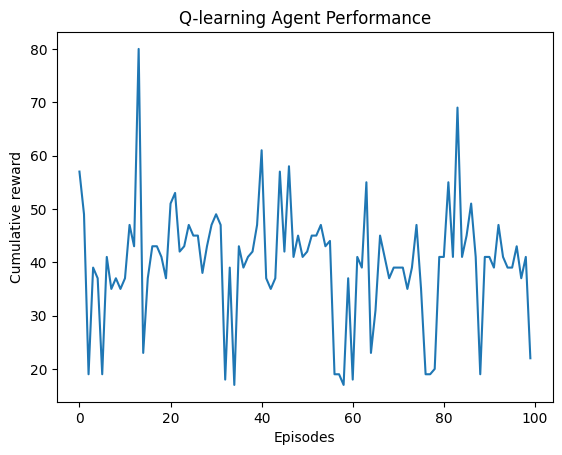

In [ ]:
ql_agent = QLearningAgent(env, alpha, gamma, epsilon, train_episodes, test_episodes, bins, lower_bounds, upper_bounds)

# training Phase
ql_agent.train_agent()
print("Train Results")
print("Average cumulative reward:", np.mean(ql_agent.training_rewards))
print("Is my agent good enough?", np.mean(ql_agent.training_rewards) > 195)

print("-----------------------------------------")

# testing Phase
ql_agent.test_agent()
print("Test Results")
print("Average cumulative reward:", np.mean(ql_agent.testing_rewards))
print("Is my agent good enough?", np.mean(ql_agent.testing_rewards) > 195)

plot_graph(ql_agent.testing_rewards, title="Q-learning Agent Performance")

While Q-learning agent performs slightly better than the random policy agent, it is still far from the baseline of 195, which suggests that the agent is not performing well enough in the Cartpole environment.

Q-learning is not always ideal for environments like Cartpole, where the state and action spaces are continuous. It requires discretising  the space which can lead to inefficiencies and poor generalisation. Additionally, Q-learning relies heavily on a well-tuned exploration-exploitation balance and may struggle with sparse rewards, making it harder to converge to an optimal policy.

To improve the performance, we would need to fine-tune parameters such as the learning rate, discount factor, exploration strategy and possibly switch to a more suitable method like deep Q-networks (DQN) for handling continuous action spaces.

## Monte Carlo REINFORCE Agent

### Introduction

Monte Carlo REINFORCE follows a policy-based approach, where it learns by observing complete episodes of interaction with the environment.

It updates its policy using the outcomes of actions chosen based on the current policy. This allows the agent to directly improve the policy it is using to make decisions, aligning the learning and exploration with the actions it actually takes.

Unlike Q-learning, REINFORCE do not require discretising the state space, as it relies on sampling entire episodes to update the policy. This allows it to learn from real experiences without needing to represent all possible states explicitly.

### Monte Carlo Control vs REINFORCE

Monte Carlo Control (covered in lectures):

focus on learning an optimal policy by estimating the action-value function for each state-action pair

REINFORCE:

focus on learning a general behaviour by estimating the gradients of the expected reward with respect to the policy parameters


### Reason for choosing REINFORCE
- Direct Policy Learning: REINFORCE directly adjusts the policy based on experience, making it well-suited for environments like CartPole with continuous action spaces, without the need to discretise actions

- Less Complexity: Since our previous attempt with Q-learning did not perform well, REINFORCE offers a simpler method by directly optimising the policy with experience-based updates, avoiding the complexity of action-value approximation altogether

### Algorithm

<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcS9hyvFuekvSfpdJJ81Pq1juVVDzVTF6_kwqA&s" width=500>

The policy is implemented using a neural network with 2 layers. The first layer processes the input state while the second layer outputs probabilities for each possible action. The agent then select actions based on these possiblities.

In [ ]:
class Policy(nn.Module):
    def __init__(self, s_size, a_size, h_size, device):
      super(Policy, self).__init__() # initialise network
      self.fc1 = nn.Linear(s_size, h_size) # first fully connected layer
      self.fc2 = nn.Linear(h_size, a_size) # second fully connected layer
      self.to(device)  # move model to the correct device (CPU/GPU) for computation

    def forward(self, x):
      x = F.relu(self.fc1(x)) # apply first layer followed by ReLU activation function
      x = self.fc2(x) # pass result through second connected layer
      return F.log_softmax(x, dim=1)

    def act(self, state):
      state = np.array(state, dtype = np.float64)
      state = torch.from_numpy(state).float().unsqueeze(0).to(device)  # convert state to tensor
      log_probs = self.forward(state).cpu()  # get log probabilities from the policy network
      m = Categorical(log_probs)  # create a categorical distribution over actions
      action = m.sample()  # sample an action
      return action.item(), m.log_prob(action)  # return action and log-probability

In [ ]:
class MonteCarloAgent:
    def __init__(self, policy, optimizer, env, gamma, train_episodes, test_episodes, max_t=1000):
      self.policy = policy
      self.optimizer = optimizer
      self.env = env
      self.gamma = gamma
      self.train_episodes = train_episodes
      self.test_episodes = test_episodes
      self.max_t = max_t
      self.training_rewards = []
      self.testing_rewards = []

    def select_action(self, state):
      action, log_prob = self.policy.act(state)
      return action, log_prob

    def train_agent(self):
      scores_deque = deque(maxlen=100) # stores scores of last 100 episodes for tracking
      scores = []

      for i_episode in range(1, self.train_episodes + 1):
          saved_log_probs = []
          rewards = []
          state, info = self.env.reset()

          for t in range(self.max_t):
              action, log_prob = self.select_action(state) # select action based on current start using the policy
              saved_log_probs.append(log_prob) # save log prob of selected action
              state, reward, done, _, _ = self.env.step(action)
              rewards.append(reward)

              if done:
                  break

          scores_deque.append(sum(rewards))
          scores.append(sum(rewards))

          returns = deque(maxlen=len(rewards))
          for t in range(len(rewards))[::-1]:
              disc_return_t = returns[0] if len(returns) > 0 else 0 # calculate return at time step
              returns.appendleft(self.gamma * disc_return_t + rewards[t])

          returns = torch.tensor(returns) # standardise returns
          eps = np.finfo(np.float32).eps.item()
          returns = (returns - returns.mean()) / (returns.std() + eps)

          policy_loss = []
          for log_prob, disc_return in zip(saved_log_probs, returns):
              policy_loss.append(-log_prob * disc_return) # compute policy loss
          policy_loss = torch.cat(policy_loss).sum() # combine all losses

          self.optimizer.zero_grad() # gradient update
          policy_loss.backward() #backpropagate policy loss to compute gradients
          self.optimizer.step() # update parameters

          self.training_rewards.append(np.mean(scores_deque))

    def test_agent(self):
      self.policy.eval()
      testing_rewards = []
      for _ in range(self.test_episodes):
          state, info = self.env.reset()
          rewards = []
          while True:
              action, _ = self.select_action(state)
              state, reward, done, _, _ = self.env.step(action)
              rewards.append(reward)
              if done:
                  break
          testing_rewards.append(sum(rewards))

      self.testing_rewards = testing_rewards
      self.policy.train()

In [ ]:
# create device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# create policy and place it to the device
policy = Policy(state_space,action_space,h_size,device).to(device)

optimizer = optim.Adam(policy.parameters(), lr=lr)

In [ ]:
# initialise agent
mc_agent_0 = MonteCarloAgent(policy, optimizer, env, gamma, train_episodes, test_episodes)

# get random initial state
observation, info = env.reset()
print("Observation:", observation)

# get chosen action
action, _ = mc_agent_0.select_action(observation)
print("Chosen action:", action)

Observation: [ 0.02325357  0.0054467  -0.02680379 -0.01945451]
Chosen action: 0


Train results
Average cumulative reward: 497.58287616405687
Is my agent good enough? True
-----------------------------------------
Test results
Average cumulative reward: 7038.31
Is my agent good enough? True


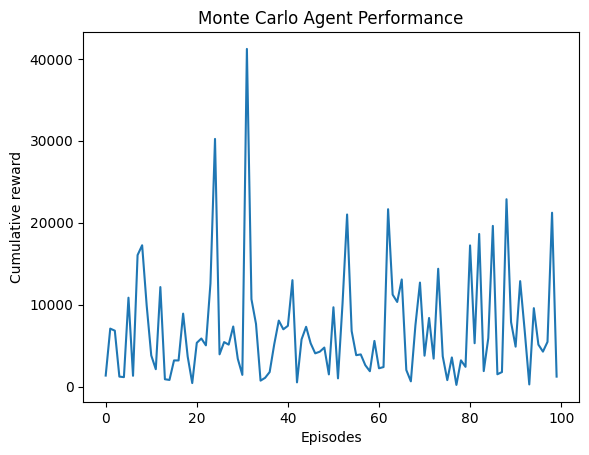

In [ ]:
# training phase
mc_agent = MonteCarloAgent(policy, optimizer, env, gamma, train_episodes, test_episodes)
mc_agent.train_agent()
print("Train results")
print("Average cumulative reward:", np.mean(mc_agent.training_rewards))
print("Is my agent good enough?", np.mean(mc_agent.training_rewards) > 195)
print("-----------------------------------------")

# testing phase
mc_agent.test_agent()
print("Test results")
print("Average cumulative reward:", np.mean(mc_agent.testing_rewards))
print("Is my agent good enough?", np.mean(mc_agent.testing_rewards) > 195)
plot_graph(mc_agent.testing_rewards, title="Monte Carlo Agent Performance")

Based on the train and test results, REINFORCE agent outperforms the Q-learning agent due to its direct policy learning approach, which is better suited for the continuous state-action space in Cartpole.

Although the REINFORCE agent is already performing very well, it could still be further optimised by experimenting with different network architectures such as deeper networks or adding more layers to capture more complex patterns in the environment. Additionally, tuning the learning rate, similar to what can be done for Q-learning, could also improve the agent's performance and convergence speed.

In [ ]:
env = RecordVideo(gym.make("CartPole-v1", render_mode="rgb_array"), "./video")
observation, info = env.reset()

while True:
    env.render()
    action, _ = mc_agent.select_action(observation)
    state, reward, done, _, _ = env.step(action)

    if done:
      break;

env.close()
show_video()

## Overview of Agents

<table border="1">
  <thead>
    <tr>
      <th>Feature</th>
      <th>Monte Carlo REINFORCE</th>
      <th>Q-Learning</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>On/Off Policy</td>
      <td>On-Policy</td>
      <td>Off-Policy</td>
    </tr>
    <tr>
      <td>Type</td>
      <td>Policy-Based</td>
      <td>Value-Based</td>
    </tr>
    <tr>
      <td>Updates</td>
      <td>After entire episode</td>
      <td>After each step</td>
    </tr>
    <tr>
      <td>Exploration</td>
      <td>policies</td>
      <td>ε-greedy exploration</td>
    </tr>
    <tr>
      <td>State Space</td>
      <td>Can handle continuous states</td>
      <td>Needs discretization or function approximation for continuous state</td>
    </tr>
    <tr>
      <td>Action Space</td>
      <td>Can handle continuous actions</td>
      <td>Discrete (or function approximation)</td>
    </tr>
    <tr>
      <td>Policy Representation</td>
      <td>Direct parameterized policy (e.g., neural network)</td>
      <td>Greedy policy derived from Q-values</td>
    </tr>
    <tr>
      <td>Policy Evaluation</td>
      <td>Direct Policy Update via Policy Gradient</td>
      <td>Value Function Estimation <br>Q(s,a)</td>
    </tr>
  </tbody>
</table>


## Conclusion

In conclusion, both Q-Learning and Monte Carlo REINFORCE are powerful reinforcement learning techniques, each suited for different types of problems. Monte Carlo is effective for learning in episodic environments where the entire episode is required before making updates, whereas Q-Learning excels in environments where real-time updates are necessary, particularly with discrete action spaces.